<a href="https://colab.research.google.com/github/mehmetkesik/tensorflow-basics/blob/main/03_computer_vision_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing the car in front.

## Get the data

The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However we've modified it to only use two classes (pizza 🍕 & steak 🥩) using the image data modification.

> 🔑 **Note:** We start with a smaller dataset so we can experiment quickly and figure what works (or better yet what doesn't work) before scaling up.

In [41]:
import tensorflow as tf

tf.__version__

'2.9.2'

In [42]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2022-11-24 12:46:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  16.3MB/s    in 7.6s    

2022-11-24 12:46:49 (13.7 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



## Inspect the data (become one with it)

A very crucial step at the begining of any machine learning project is becoming one with the data.

And for a computer vision project... this usually means visualizing many samples of your data.

In [43]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in 'pizza_steak'
There are 2 directories and 0 images in 'pizza_steak/train'
There are 0 directories and 750 images in 'pizza_steak/train/steak'
There are 0 directories and 750 images in 'pizza_steak/train/pizza'
There are 2 directories and 0 images in 'pizza_steak/test'
There are 0 directories and 250 images in 'pizza_steak/test/steak'
There are 0 directories and 250 images in 'pizza_steak/test/pizza'


In [44]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

To visualize our images, first let's get the class name progmmatically.

In [45]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [46]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # Show the shape of the image

  return img

['31881.jpg']
Image shape: (512, 384, 3)


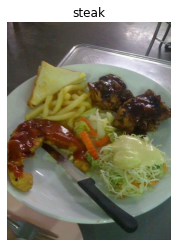

In [47]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

In [48]:
import tensorflow as tf
tf.constant(img)

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[73, 58, 55],
        [78, 63, 60],
        [85, 69, 69],
        ...,
        [37, 57, 45],
        [41, 65, 51],
        [35, 62, 47]],

       [[71, 56, 53],
        [76, 61, 58],
        [83, 67, 67],
        ...,
        [30, 50, 39],
        [24, 46, 33],
        [30, 54, 40]],

       [[72, 57, 54],
        [77, 62, 59],
        [84, 68, 68],
        ...,
        [60, 77, 67],
        [40, 62, 49],
        [26, 50, 36]],

       ...,

       [[79, 73, 41],
        [74, 68, 36],
        [74, 65, 34],
        ...,
        [56, 65, 60],
        [56, 65, 60],
        [56, 67, 61]],

       [[76, 73, 40],
        [73, 68, 36],
        [71, 66, 34],
        ...,
        [55, 66, 62],
        [55, 66, 60],
        [56, 67, 61]],

       [[64, 64, 30],
        [66, 63, 30],
        [68, 65, 32],
        ...,
        [54, 66, 62],
        [54, 67, 60],
        [55, 68, 61]]], dtype=uint8)>

In [49]:
img.shape

(512, 384, 3)

In [50]:
# Get all the pixel values between 0 & 1
img/255.

array([[[0.28627451, 0.22745098, 0.21568627],
        [0.30588235, 0.24705882, 0.23529412],
        [0.33333333, 0.27058824, 0.27058824],
        ...,
        [0.14509804, 0.22352941, 0.17647059],
        [0.16078431, 0.25490196, 0.2       ],
        [0.1372549 , 0.24313725, 0.18431373]],

       [[0.27843137, 0.21960784, 0.20784314],
        [0.29803922, 0.23921569, 0.22745098],
        [0.3254902 , 0.2627451 , 0.2627451 ],
        ...,
        [0.11764706, 0.19607843, 0.15294118],
        [0.09411765, 0.18039216, 0.12941176],
        [0.11764706, 0.21176471, 0.15686275]],

       [[0.28235294, 0.22352941, 0.21176471],
        [0.30196078, 0.24313725, 0.23137255],
        [0.32941176, 0.26666667, 0.26666667],
        ...,
        [0.23529412, 0.30196078, 0.2627451 ],
        [0.15686275, 0.24313725, 0.19215686],
        [0.10196078, 0.19607843, 0.14117647]],

       ...,

       [[0.30980392, 0.28627451, 0.16078431],
        [0.29019608, 0.26666667, 0.14117647],
        [0.29019608, 0

## An end-to-end example

Let's build a convolutional neural network to find patterns in our images, more specifically we a need way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [51]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers

tf.random.set_seed(42)

train_dir = "/content/pizza_steak/train"
test_dir = "/content/pizza_steak/test"

normalization_layer = layers.Rescaling(1./255)

train_data = image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(224, 224),
    batch_size=32
)
train_data = train_data.map(lambda x, y: (normalization_layer(x), y)) # Rescale our data 0 & 1 using map and keras.layers.Rescaling

valid_data = image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(224, 224),
    batch_size=32
).map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [52]:
#for (X, y) in train_data:
  #print(X)

In [53]:
# Build a CNN model (same as the Tiny VGG on the CNN explainer website)

In [54]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    #tf.keras.layers.Activations(tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")                       
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 6s 111ms/step - loss: 0.5965 - accuracy: 0.6800 - val_loss: 0.4562 - val_accuracy: 0.7720
Epoch 2/5
47/47 [==============================] - 2s 41ms/step - loss: 0.4539 - accuracy: 0.7920 - val_loss: 0.5086 - val_accuracy: 0.7500
Epoch 3/5
47/47 [==============================] - 2s 40ms/step - loss: 0.4461 - accuracy: 0.7900 - val_loss: 0.3924 - val_accuracy: 0.8180
Epoch 4/5
47/47 [==============================] - 2s 40ms/step - loss: 0.4021 - accuracy: 0.8200 - val_loss: 0.3528 - val_accuracy: 0.8300
Epoch 5/5
47/47 [==============================] - 2s 40ms/step - loss: 0.3651 - accuracy: 0.8380 - val_loss: 0.3462 - val_accuracy: 0.8460


In [55]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 29160)            

## Using the same model as before

Let's replicate the model we've built in a previous section to see if it works with our image.

In [56]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 1s 12ms/step - loss: 1.3170 - accuracy: 0.4953 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [57]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 4)                 602116    
                                                                 
 dense_5 (Dense)             (None, 4)                 20        
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Improve model_2

In [58]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 1s 16ms/step - loss: 3.4676 - accuracy: 0.6307 - val_loss: 0.4825 - val_accuracy: 0.7780
Epoch 2/5
47/47 [==============================] - 1s 13ms/step - loss: 0.6629 - accuracy: 0.7460 - val_loss: 0.5552 - val_accuracy: 0.7460
Epoch 3/5
47/47 [==============================] - 1s 13ms/step - loss: 0.6133 - accuracy: 0.7447 - val_loss: 0.7452 - val_accuracy: 0.6560
Epoch 4/5
47/47 [==============================] - 1s 13ms/step - loss: 0.5326 - accuracy: 0.7793 - val_loss: 0.5276 - val_accuracy: 0.7560
Epoch 5/5
47/47 [==============================] - 1s 13ms/step - loss: 0.4351 - accuracy: 0.8100 - val_loss: 0.4734 - val_accuracy: 0.7840


In [59]:
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 150528)            0         
                                                                 
 dense_7 (Dense)             (None, 100)               15052900  
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


## Binary Classification: Let's break it down

1. Become one with the data (visualize, visualize, visualize)
2. Preprocess the data (prepared it for our model, the main step here was scaling/normalizing)
3. Created a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameter and improve the model (try to beat our baseline)
7. Repeat until satisfied (experiment, experiment, experiment)

### 1. Become one with the data

['2020613.jpg']
Image shape: (512, 512, 3)
['2312987.jpg']
Image shape: (512, 512, 3)


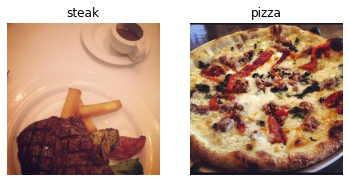

In [60]:
# Visualize data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### 2. Preprocess the data (prepare it for a model)

In [61]:
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test"

Our next step is to turn our data into **batches**.

A batch is a small subsert of data. Rather than look at all 10,000 images at one time, a model might only look at 32 at a time.

It does this for a couple of reasons:
1. 10,000 images (or more) might not fit into the memory of your processor(GPU).
2. Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

In [62]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers

normalized_layer = layers.Rescaling(1./255)

In [63]:
train_data = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    seed=42
).map(lambda x, y: (normalized_layer(x), y))

test_data = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    seed=42
).map(lambda x, y: (normalization_layer(x), y))

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [64]:
images, labels = train_data.as_numpy_iterator().next()
len(images), len(labels)

(32, 32)

In [65]:
len(train_data)

47

In [66]:
images[:1], images[0].shape

(array([[[[0.4200343 , 0.21826607, 0.0646071 ],
          [0.42573532, 0.22396712, 0.07030813],
          [0.40404415, 0.20940128, 0.06526611],
          ...,
          [0.02177135, 0.02006294, 0.00930718],
          [0.00733047, 0.00671524, 0.        ],
          [0.00458801, 0.01289256, 0.        ]],
 
         [[0.414302  , 0.22429848, 0.06743573],
          [0.4171744 , 0.22717088, 0.07030813],
          [0.39822558, 0.21645035, 0.06603517],
          ...,
          [0.01253501, 0.00899231, 0.00468559],
          [0.0022735 , 0.00091178, 0.        ],
          [0.00340993, 0.01531221, 0.00430672]],
 
         [[0.40368024, 0.2308261 , 0.06806723],
          [0.4082283 , 0.23742497, 0.07364072],
          [0.40043646, 0.22755478, 0.07461361],
          ...,
          [0.01601891, 0.00133053, 0.00066526],
          [0.01333015, 0.01335391, 0.01384295],
          [0.        , 0.01111508, 0.0237375 ]],
 
         ...,
 
         [[0.02352941, 0.00717773, 0.00358887],
          [0.02717

### 3. Create a CNN model (start with baseline)

In [67]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [68]:
model_4 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding="valid",
           activation="relu",
           input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    Flatten(),
    Dense(1, activation="sigmoid")
])

**Note:** Look at CNN Explainer website to undersitand CNN's: https://poloclub.github.io/cnn-explainer/

In [69]:
model_4.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [70]:
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_12 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 conv2d_13 (Conv2D)          (None, 218, 218, 10)      910       
                                                                 
 flatten_6 (Flatten)         (None, 475240)            0         
                                                                 
 dense_11 (Dense)            (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### 4. Fit the model

In [71]:
len(train_data), len(test_data)

(47, 16)

In [72]:
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data)
                        )

Epoch 1/5
47/47 [==============================] - 6s 102ms/step - loss: 0.9645 - accuracy: 0.6867 - val_loss: 0.4623 - val_accuracy: 0.7860
Epoch 2/5
47/47 [==============================] - 5s 93ms/step - loss: 0.4516 - accuracy: 0.8007 - val_loss: 0.4155 - val_accuracy: 0.8300
Epoch 3/5
47/47 [==============================] - 5s 94ms/step - loss: 0.3285 - accuracy: 0.8727 - val_loss: 0.4064 - val_accuracy: 0.8100
Epoch 4/5
47/47 [==============================] - 5s 93ms/step - loss: 0.1413 - accuracy: 0.9560 - val_loss: 0.4542 - val_accuracy: 0.7940
Epoch 5/5
47/47 [==============================] - 5s 93ms/step - loss: 0.0409 - accuracy: 0.9927 - val_loss: 0.5416 - val_accuracy: 0.8160


In [73]:
model_1.evaluate(test_data)

16/16 [==============================] - 1s 37ms/step - loss: 0.3462 - accuracy: 0.8460


[0.34615227580070496, 0.8460000157356262]

### 5. Evaluating our model

Is looks like our model is learning something, let's evaluate it.

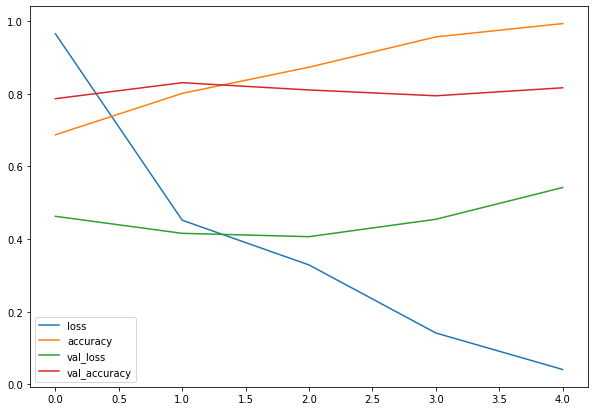

In [74]:
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7))

In [75]:
# Plot the validation and training curves seperately
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_acc")
  plt.plot(epochs, val_accuracy, label="val_acc")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

> 🔑 **Note:** When a model's **validation loss starts to increase**, it's likely taht the model is **overfitting** the training dataset. This means, it's learining the patterns in the training dataset *too well* and thus the model's ability to generalize to unseen data will be deminished.

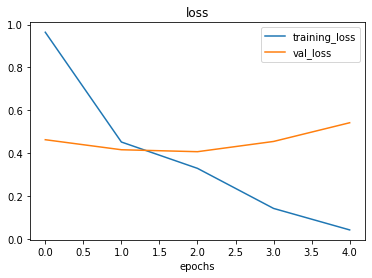

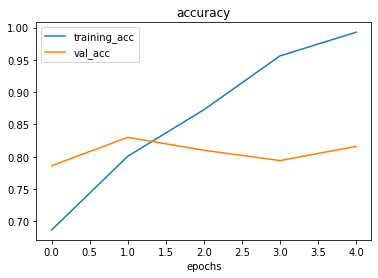

In [76]:
# Check out the loss and accuracy of model_4
plot_loss_curves(history_4)

### 6. Adjust the model parameters

Fitting a machine learning model comes in 3 steps:

0. Create a baseline
1. Beat the baseline by overfitting a larger model
2. Reduce overfitting

Ways to induce overfitting:
* Increase the numver of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of our flattened layer

Reduce overfitting:
* Add data augmentation
* Add regularization layers (such as MaxPool2D)
* Add more data...

> 🔑 **Note:** Reducing overfitting is also known as **regularization**

In [77]:
# Create the model (this is going to be our new baseline)
model_5 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [78]:
model_5.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [79]:
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 5s 87ms/step - loss: 0.6031 - accuracy: 0.6840 - val_loss: 0.5377 - val_accuracy: 0.7600
Epoch 2/5
47/47 [==============================] - 4s 85ms/step - loss: 0.4836 - accuracy: 0.7907 - val_loss: 0.4041 - val_accuracy: 0.8360
Epoch 3/5
47/47 [==============================] - 4s 85ms/step - loss: 0.4279 - accuracy: 0.8147 - val_loss: 0.3854 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 4s 86ms/step - loss: 0.4146 - accuracy: 0.8200 - val_loss: 0.3487 - val_accuracy: 0.8500
Epoch 5/5
47/47 [==============================] - 5s 87ms/step - loss: 0.3939 - accuracy: 0.8353 - val_loss: 0.3395 - val_accuracy: 0.8580


In [80]:
model_5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 10)      

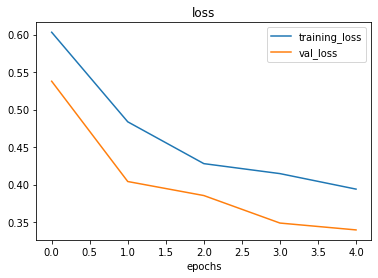

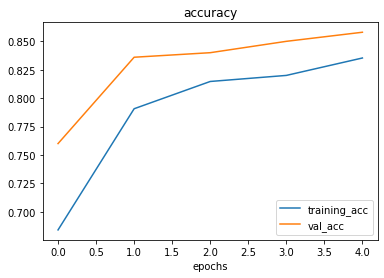

In [81]:
plot_loss_curves(model_5.history)

### Opening our bag of tricks and finding data augmentation

In [82]:
data_augmentation = Sequential([
    #layers.Rescaling(1./255),
    layers.RandomRotation(0.2),
    #layers.RandomCrop(210, 210),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.9)
])

In [83]:
AUTOTUNE = tf.data.AUTOTUNE

rescale = layers.Rescaling(1./255)

train_data = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    seed=42,
    shuffle=True
).map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

train_data_aug = train_data.map(lambda x, y: (data_augmentation(x), y), 
      num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

test_data = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    seed=42,
    shuffle=False
).map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

#test_data_aug = test_data.map(lambda x, y: (data_augmentation(x), y), 
#      num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [84]:
#import matplotlib.pyplot as plt
images, labels = next(iter(train_data_aug))
labels
class_names[labels[0]]
images_t, labels_t = next(iter(test_data))
len(images), images.shape, images_t.shape

(32, TensorShape([32, 224, 224, 3]), TensorShape([32, 224, 224, 3]))

32


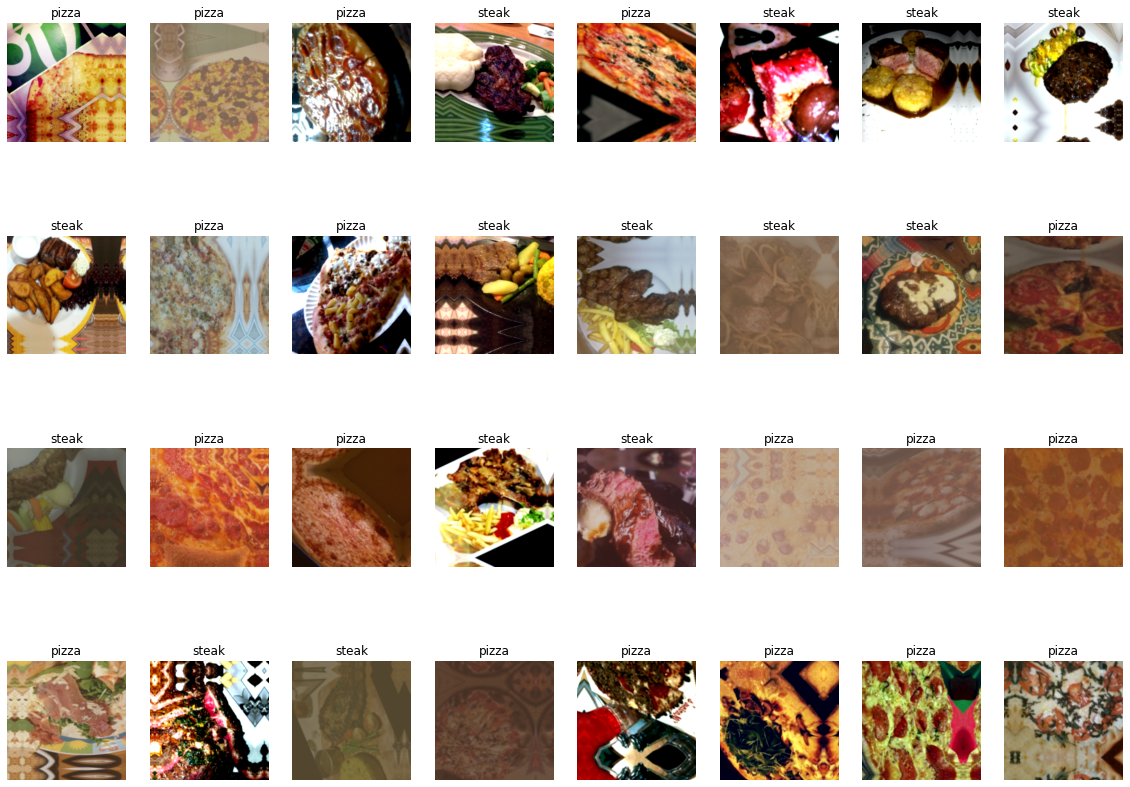

In [85]:
images, labels = next(iter(train_data_aug))
print(len(images))

fig = plt.figure(figsize=(20, 15))

for idx in range(len(images)):
    ax = fig.add_subplot(4, 8, idx+1)
    ax.imshow(images[idx])
    ax.title.set_text(class_names[labels[idx]])
    ax.axis(False)

In [86]:
image, label = next(iter(train_data))
print(image[0].shape)
data_augmentation(image[0]).shape

(224, 224, 3)


TensorShape([224, 224, 3])

Now we've seen what augmented training data looks like, let's build a model and see how it learns on augmented data.

In [ ]:
# Create a model (same as model_5)
model_6 = Sequential([
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_6 = model_6.fit(train_data_aug, # fitting model_6 on augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_aug),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 21s 423ms/step - loss: 0.6612 - accuracy: 0.5780 - val_loss: 0.5554 - val_accuracy: 0.7460
Epoch 2/5
47/47 [==============================] - 21s 419ms/step - loss: 0.5792 - accuracy: 0.6807 - val_loss: 0.4583 - val_accuracy: 0.7940
Epoch 3/5
47/47 [==============================] - 21s 418ms/step - loss: 0.5395 - accuracy: 0.7360 - val_loss: 0.4506 - val_accuracy: 0.7900
Epoch 4/5
47/47 [==============================] - 21s 420ms/step - loss: 0.5328 - accuracy: 0.7287 - val_loss: 0.3899 - val_accuracy: 0.8440
Epoch 5/5
 5/47 [==>...........................] - ETA: 18s - loss: 0.4962 - accuracy: 0.7563

In [ ]:
# Check our model training curves
plot_loss_curves(history_6)

### 7. Repeat until satisfied

Since we've already beaten our baseline, there are a few things we could try to continue improve our model:

* Increase the number of model layers (e.g add more `Conv2D`/`MaxPool2D` layers)
* Increase the number of filters in each convolutional layer (e.g from 10 to 32 or even 64)
* Train for longer (more epochs)
* Find an ideal learning rate
* Get more data (give the model more opportunities to learn)
* User **transfer learning** to leverage what another image model has learn and adjust it for our own use case.

## Making a prediction with our trained model on our own custom data

In [ ]:
print(class_names)

In [ ]:
import matplotlib.image as mpimg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False)

In [ ]:
# Check the shape of our image
steak.shape

In [ ]:
# Create a fucntion to import and resize it to be able to be used with our model
def load_and_pred_image(filename, img_shape=224):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img 

In [ ]:
# Load in and preprocess our custom image
steak = load_and_pred_image("03-steak.jpeg")
steak

In [ ]:
expanded_steak = tf.expand_dims(steak, 0)
expanded_steak.shape

In [ ]:
pred = model_6.predict(expanded_steak)
pred

Looks like our custom image is being put through our model, however, it currently outputs a prediction probability, wouldn't it be nice if we could visualize the image as well as the model's prediction?

In [ ]:
# Remind ourselves of our class names
class_names

In [ ]:
# We can index the predicted class by rounding the prediction probability and indexing it on the class names
pred_class = class_names[int(tf.round(pred))]
pred_class

In [ ]:
def pred_and_plot(model, filename, class_names=class_names):
  # Import the target image and preprocess it
  img = load_and_pred_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

In [ ]:
# Test our model on a custom image
pred_and_plot(model_6, "03-steak.jpeg")

Our model works! Let's try it on another image... this time pizza 🍕

In [ ]:
# Download another test custom image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
pred_and_plot(model_6, "03-pizza-dad.jpeg")

# Multi-class Image Classification

We've just been through a bunch of the following steps with a binary classification problem (pizza & steak), now going to step things up a notch with 10 classes of food (multi-class classification).

1. Become one with the data
2. Preprocess the data (get it ready for a model)
3. Create a model (start with a baseline)
4. Fit the model (overfit it to make sure it works)
5. Evaluate the model
6. Adjust differet hyperparameters and improve the model (try to beat baseline/reduce overfitting)
7. Repeat until satisfied

## Import and become one with the data

In [ ]:
# Download helper functions
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mehmetkesik/tensorflow-basics/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
# Import helper functions
from helper_functions import *

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

# Walk through 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# Let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

In [ ]:
# Visualize
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

### 2. Preprocess the data (prepare it for a model)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers

In [ ]:
rescale = layers.Rescaling(1./255)
IMG_SIZE = (224, 224)
train_data = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=32,
    seed=42,
    label_mode='categorical'
)#.map(lambda x, y : (rescale(x), y))

test_data = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=32,
    seed=42,
    shuffle=False,
    label_mode='categorical'
)#.map(lambda x, y : (rescale(x), y))

In [ ]:
for (images, labels) in train_data.take(1):
    print(images.shape)
    print(labels.shape)
for (images, labels) in test_data.take(1):
    print(images.shape)
    print(labels.shape)

### 3. Create a model (start with a baseline)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam

# Create model like CNN Explainer website model
model_7 = Sequential([
    Conv2D(10, 3, input_shape=(224, 224, 3)),
    Activation(activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax") # changed to have 10 output neurons and use the softmax activation function
])

model_7.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])



### 4. Fit a model

In [ ]:
history_7 = model_7.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

### 5. Evaluate the model

In [ ]:
# Evaluate on the test data
model_7.evaluate(test_data)

In [ ]:
# Check out the model's loss curves
plot_loss_curves(history_7)

It seems our model is **overfitting**.

### 6. Adjust the model hyperparameters (to beat the baseline/reduce overfitting)

Due to its performance on the training data, it's clear our model is learning something...

However, it's not generalizing well to unseen data (overfitting).

So, let's try and fix overfitting by...

* **Get more data** - having more data gives a model more opportunity to learn diverse patterns...
* **Simplify the model** - if our current model is overfitting the data, it may be to complicated of a model, one way to simplify a model is to: reduce # of layers or reduce # hidden units in layers
* **User data augmentation** - data augmentation manipulates the training data in such a way to add more diversity to it (without altering the original data)
* **Use transfer learning** - transfer learning leverages the patterns another model has learned on similar data to your own and allows you to use those patterns on your own dataset

In [ ]:
# How about we try and simplify the model first?
# Let's try to remove 2 convolutional layers...

model_8 = Sequential([
    Conv2D(10, 3, input_shape=(224, 224, 3), activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax")
])

model_8.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
history_8 = model_8.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

In [ ]:
# Check out the loss curves model_9
plot_loss_curves(history_8)

Looks like our "smiplifying the model" experiment didn't work... the accuracy went down and overfitting continued...

How about we try data augmentation??

### Trying to reduce overfitting with data augmentation

Let's try and improve our model's results by using augmented training data...

Ideally, we want to:
* Reduce overfitting (get the train and validation loss curves closer)
* Improve validation accuracy

In [ ]:
# Let's create another model with data augmentation
model_9 = Sequential([
    #Augment
    layers.Rescaling(1./255),
    layers.RandomRotation(0.2),
    layers.RandomCrop(210, 210),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.9),
    #design
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax")
])

model_9.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])


#model_9.build(input_shape=(None, 224, 224, 3))

In [119]:
history_9 = model_9.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 77s 306ms/step - loss: 2.2382 - accuracy: 0.1835 - val_loss: 2.0941 - val_accuracy: 0.2440
Epoch 2/5
235/235 [==============================] - 72s 305ms/step - loss: 2.1118 - accuracy: 0.2415 - val_loss: 2.0110 - val_accuracy: 0.2884
Epoch 3/5
235/235 [==============================] - 71s 302ms/step - loss: 2.0577 - accuracy: 0.2685 - val_loss: 1.9510 - val_accuracy: 0.3116
Epoch 4/5
235/235 [==============================] - 71s 301ms/step - loss: 2.0626 - accuracy: 0.2612 - val_loss: 1.9423 - val_accuracy: 0.3120
Epoch 5/5
235/235 [==============================] - 73s 310ms/step - loss: 2.0429 - accuracy: 0.2724 - val_loss: 1.9395 - val_accuracy: 0.3084


In [120]:
model_9.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_crop_2 (RandomCrop)  (None, 210, 210, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 210, 210, 3)       0         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 210, 210, 3)       0         
                                                                 
 random_translation_3 (Rando  (None, 210, 210, 3)      0         
 mTranslation)                                       

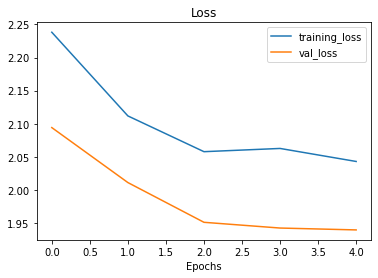

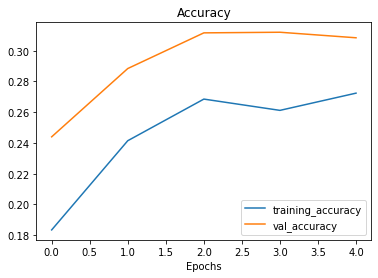

In [121]:
plot_loss_curves(history_9)

That looks much better, the loss curves are much closer to each other that the baseline model and they look like they're heading in the right direction (certainly not the wrong direction) so if we were to train for longer, we might see further improvements.

### 7. Repeat until satisfied

We could keep going here... continally trying to bring our loss curves closer together and trying to improve the validation/test accuracy.

How?

By running lots of experiments,namely:
- restructuring our model's architecture (increasing layers/hidden units)
- adjust the learning rate
- try different methods of data augmentation
- training for longer (e.g 10 epochs instead 5 epochs)
- try **transfer learning**

### Making a prediction with our trained model

Let's use our trained model to make some predictions on our own custom images!

In [122]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [123]:
# Download some custom images
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

--2022-11-24 13:02:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3564285 (3.4M) [image/jpeg]
Saving to: ‘03-hamburger.jpeg.1’

03-hamburger.jpeg.1 100%[===================>]   3.40M  --.-KB/s    in 0.01s   

2022-11-24 13:02:15 (299 MB/s) - ‘03-hamburger.jpeg.1’ saved [3564285/3564285]

--2022-11-24 13:02:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting 

1/1 [==============================] - 0s 98ms/step


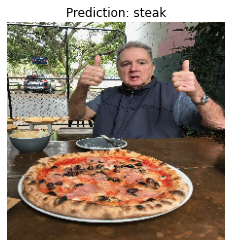

In [124]:
# Make a prediction using model_9
pred_and_plot(model=model_9,
              filename="03-pizza-dad.jpeg",
              class_names=class_names)

1/1 [==============================] - 0s 19ms/step


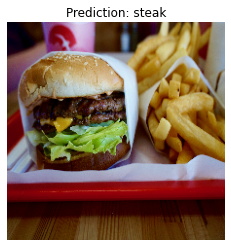

In [125]:
pred_and_plot(model=model_9,
              filename="03-hamburger.jpeg",
              class_names=class_names)

Looks like our model didn't perform very well on our custom images but this because it only achieved ~35% accuracy on the test data. So we can expect it to function quite poorly on other unseed data.

## Saving and loading our model

In [126]:
# Save a model
tf.get_logger().setLevel('ERROR')
model_9.save("saved_trained_model_9")

In [127]:
# Load in a trained model and evaluate it
loaded_model_9 = tf.keras.models.load_model("saved_trained_model_9")
loaded_model_9.evaluate(test_data)

79/79 [==============================] - 5s 62ms/step - loss: 1.9395 - accuracy: 0.3084


[1.9394761323928833, 0.3084000051021576]

In [ ]:
# Compare our loaded model to our existing model
model_9.evaluate(test_data)

1/1 [==============================] - 0s 18ms/step


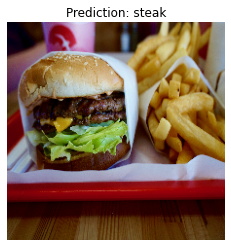

In [130]:
pred_and_plot(model=loaded_model_9,
              filename="03-hamburger.jpeg",
              class_names=class_names)